In [98]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import dates
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pickle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, explained_variance_score
from skimage.metrics import normalized_root_mse

In [99]:
dataset = pd.read_csv('Edited_Korea_Original.csv')
dataset

,Measurement date,Station code,SO2,NO2,O3,CO,PM10,PM2.5
0,2017-01-01 00:00,101,0.004,0.059,0.002,1.2,73.0,57.0
1,2017-01-01 00:00,102,0.006,0.068,0.002,1.3,77.0,63.0
2,2017-01-01 00:00,103,0.005,0.039,0.002,1.4,70.0,68.0
3,2017-01-01 00:00,104,0.005,0.045,0.003,0.6,73.0,46.0
4,2017-01-01 00:00,105,0.005,0.044,0.004,1.0,81.0,44.0
...,...,...,...,...,...,...,...,...
656995,2019-12-31 23:00,121,0.003,0.042,0.013,0.5,29.0,16.0
656996,2019-12-31 23:00,122,0.003,0.047,0.007,0.4,24.0,15.0
656997,2019-12-31 23:00,123,0.003,0.039,0.003,0.5,19.0,13.0
656998,2019-12-31 23:00,124,0.003,0.035,0.004,0.5,20.0,13.0


In [100]:
df = dataset[dataset['Station code'] == 101].iloc[:,-2:]
df

,PM10,PM2.5
0,73.0,57.0
25,71.0,59.0
50,70.0,59.0
75,70.0,58.0
100,69.0,61.0
...,...,...
656875,26.0,19.0
656900,27.0,19.0
656925,23.0,18.0
656950,20.0,19.0


In [101]:
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(df)
df1.shape

(26280, 2)

In [102]:
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step)]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step])
	return np.array(dataX), np.array(dataY)

In [103]:
time_step = 36
training_size = int(len(df1)*0.7)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size,:], df1[training_size - time_step:len(df1),:]
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [104]:
training_size, test_size

(18396, 7884)

In [105]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((18359, 36, 2), (18359, 2), (7883, 36, 2), (7883, 2))

In [106]:
learning_rate = 0.001
model = Sequential()
model.add(LSTM(128, return_sequences = True, input_shape = (X_test.shape[1:])))
model.add(LSTM(128, return_sequences = True))
model.add(LSTM(128))
#model.add(Activation('softmax'))
model.add(Dense(X_test.shape[2]))
model.compile(optimizer = keras.optimizers.Adam(learning_rate = learning_rate), loss = "mean_absolute_error", metrics = ['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 36, 128)           67072     
_________________________________________________________________
lstm_16 (LSTM)               (None, 36, 128)           131584    
_________________________________________________________________
lstm_17 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 330,498
Trainable params: 330,498
Non-trainable params: 0
_________________________________________________________________


In [107]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor = "val_loss", min_delta = 0, patience = 5, restore_best_weights=True)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor = "val_loss",
    filepath = path_checkpoint,
    verbose = 1,
    save_weights_only = True,
    save_best_only = True,
)

history = model.fit(
    X_train,
    y_train,
    validation_data = (X_test, y_test),
    epochs = 100,
    batch_size = 256,
    verbose = 1,
    callbacks = [es_callback, modelckpt_callback]
    )

Epoch 1/100
72/72 [==============================] - 12s 107ms/step - loss: 0.0475 - accuracy: 0.9487 - val_loss: 0.0337 - val_accuracy: 0.9893

Epoch 00001: val_loss improved from inf to 0.03367, saving model to model_checkpoint.h5
Epoch 2/100
72/72 [==============================] - 8s 116ms/step - loss: 0.0322 - accuracy: 0.9887 - val_loss: 0.0277 - val_accuracy: 0.9877

Epoch 00002: val_loss improved from 0.03367 to 0.02771, saving model to model_checkpoint.h5
Epoch 3/100
72/72 [==============================] - 9s 121ms/step - loss: 0.0260 - accuracy: 0.9887 - val_loss: 0.0223 - val_accuracy: 0.9883

Epoch 00003: val_loss improved from 0.02771 to 0.02228, saving model to model_checkpoint.h5
Epoch 4/100
72/72 [==============================] - 9s 122ms/step - loss: 0.0218 - accuracy: 0.9875 - val_loss: 0.0218 - val_accuracy: 0.9825

Epoch 00004: val_loss improved from 0.02228 to 0.02177, saving model to model_checkpoint.h5
Epoch 5/100
72/72 [==============================] - 9s 121

In [108]:
#model.save_weights('lstm_model')

In [109]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [110]:
features = df.columns.values
features

array(['PM10', 'PM2.5'], dtype=object)

In [111]:
print('Train values')
for i, feature in enumerate(features):
    obj = [j[i] for j in scaler.inverse_transform(y_train)]
    pred = [j[i] for j in scaler.inverse_transform(train_predict)]
    print(f'RMSE for {feature} is {mean_squared_error(obj, pred, squared=False)}')
    print(f'CV for {feature} is {explained_variance_score(obj, pred)}')
    print(f'NRMSE {normalized_root_mse(np.array(obj), np.array(pred))}')
    print()

Train values
RMSE for PM10 is 8.06654842060047
CV for PM10 is 0.8941744049204038
NRMSE 0.17685864987454022

RMSE for PM2.5 is 5.4603408658022925
CV for PM2.5 is 0.8996313635470082
NRMSE 0.19088008199177195



In [112]:
print('Test values')
for i, feature in enumerate(features):
    obj = [j[i] for j in scaler.inverse_transform(y_test)]
    pred = [j[i] for j in scaler.inverse_transform(test_predict)]
    print(f'RMSE for {feature} is {mean_squared_error(obj, pred, squared=False)}')
    print(f'CV for {feature} is {explained_variance_score(obj, pred)}')
    print()


Test values
RMSE for PM10 is 9.413029287628204
CV for PM10 is 0.8495021182369213

RMSE for PM2.5 is 7.822456472642494
CV for PM2.5 is 0.7895990582007052



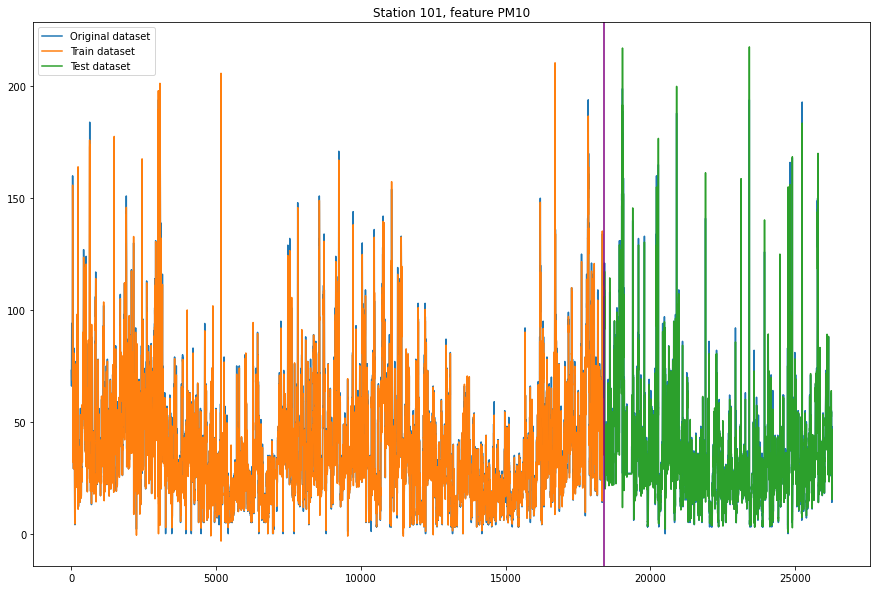

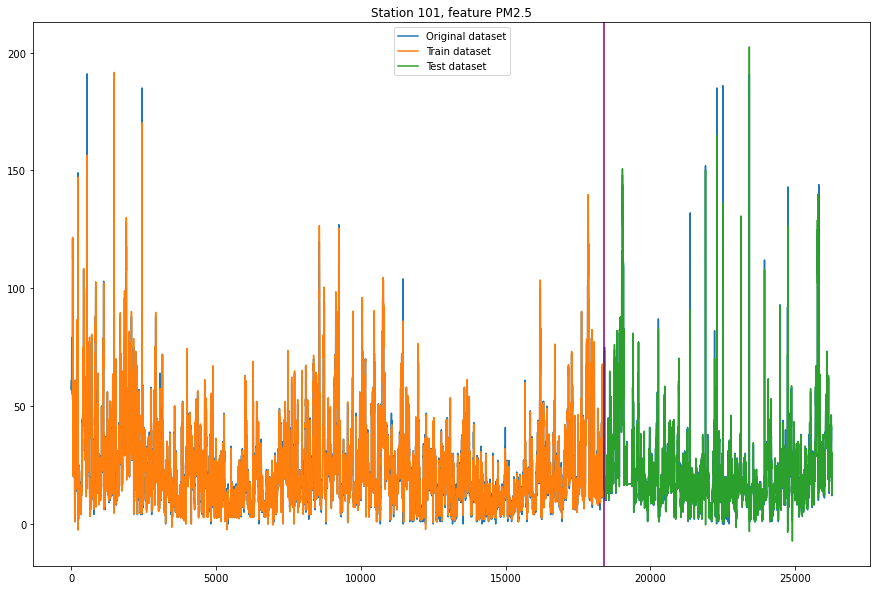

In [113]:

for indi, feature in enumerate(features):

    trainPredictPlot = np.empty_like(df1)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_step:len(train_predict)+time_step, :] = scaler.inverse_transform(train_predict)
    
   
    testPredictPlot = np.empty_like(df1)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(time_step*2)+1-time_step:len(df1)-1, :] = scaler.inverse_transform(test_predict)
    
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(10)
    
    plt.plot(scaler.inverse_transform(df1)[:, indi], label = 'Original dataset')    
    plt.plot(trainPredictPlot[:, indi], label = 'Train dataset')
    plt.plot(testPredictPlot[:, indi], label = 'Test dataset')
    
    plt.axvline(x = len(train_predict) + time_step, color = 'purple')
    plt.title(f"Station 101, feature {feature}")
    plt.legend()
    plt.show()

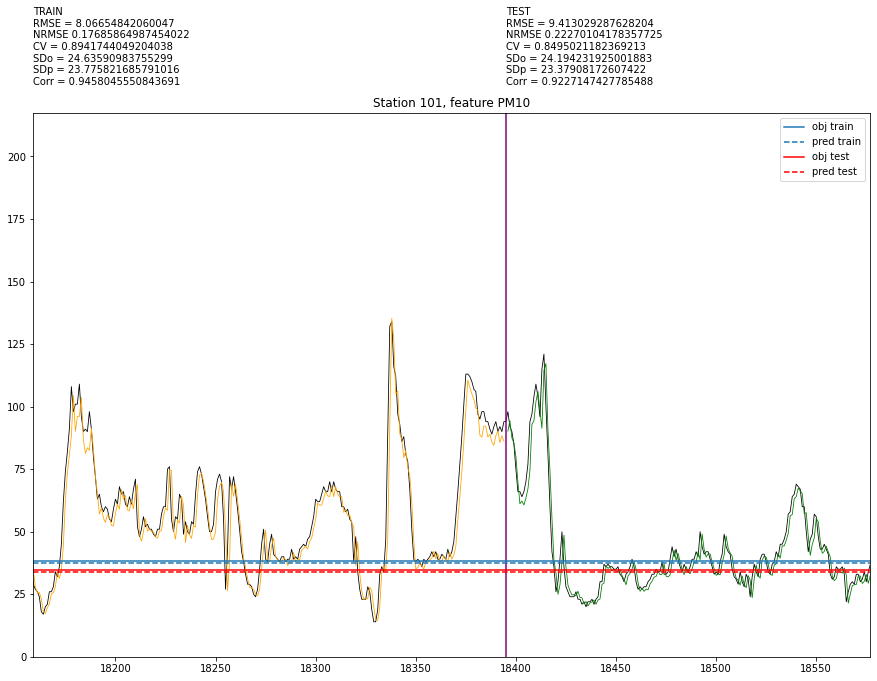

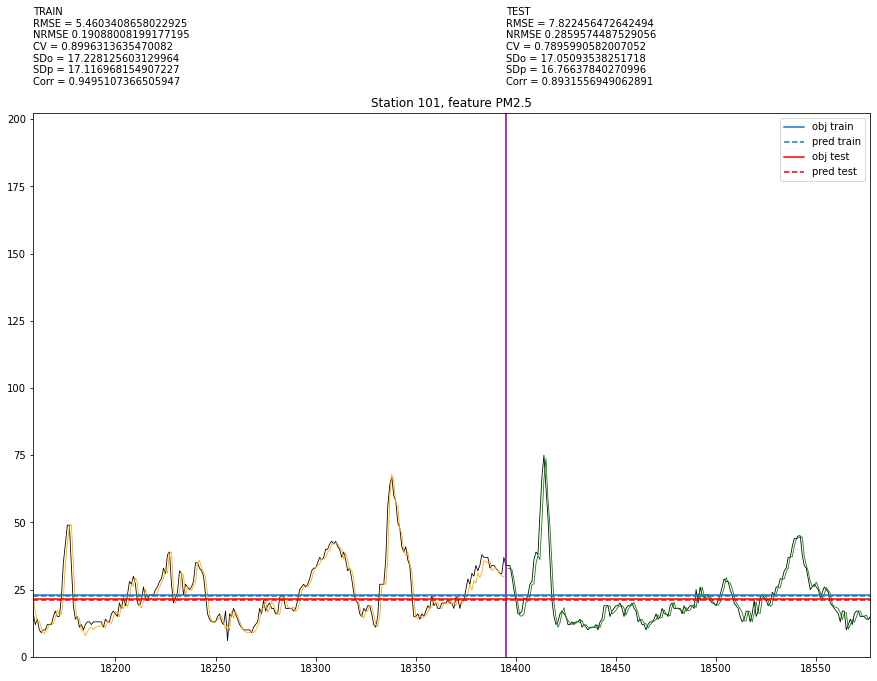

In [114]:
shift = 200
for indi, feature in enumerate(features):
 
    trainPredictPlot = np.empty_like(df1)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[time_step:len(train_predict)+time_step, :] = scaler.inverse_transform(train_predict)
    
    testPredictPlot = np.empty_like(df1)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(train_predict)+(time_step*2)+1-time_step:len(df1)-1, :] = scaler.inverse_transform(test_predict)
    
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(10)

    plt.plot(scaler.inverse_transform(df1)[:, indi], color = 'black', linewidth = 0.8)
    plt.plot(trainPredictPlot[:, indi], color = 'orange', linewidth = 0.8)
    plt.plot(testPredictPlot[:, indi], color = 'green', linewidth = 0.8)

    xmin, xmax, ymin, ymax = plt.axis()
    plt.axis([len(train_predict) - shift, len(train_predict)+time_step/2 + shift, 0, ymax*0.95])

    plt.axvline(x=len(train_predict)+time_step, color = 'purple')
    plt.axhline(y = scaler.inverse_transform(y_train)[:,indi].mean(), label = 'obj train')
    plt.axhline(y = scaler.inverse_transform(train_predict)[:,indi].mean(), label = 'pred train', linestyle = 'dashed')
    plt.axhline(y = scaler.inverse_transform(y_test)[:,indi].mean(), label = 'obj test', color = 'red')
    plt.axhline(y = scaler.inverse_transform(test_predict)[:,indi].mean(), label = 'pred test', color = 'red', linestyle = 'dashed')
    

    obj = np.array([j[indi] for j in scaler.inverse_transform(y_train)])
    pred = np.array([j[indi] for j in scaler.inverse_transform(train_predict)])    
    plt.text(len(train_predict) - shift, ymax, 
    f"""TRAIN
RMSE = {mean_squared_error(obj, pred, squared=False)}
NRMSE {normalized_root_mse(obj, pred)}
CV = {explained_variance_score(obj, pred)}
SDo = {obj.std()}
SDp = {pred.std()}
Corr = {np.corrcoef(np.vstack((obj, pred)))[0][1]}""")


    obj = np.array([j[indi] for j in scaler.inverse_transform(y_test)])
    pred = np.array([j[indi] for j in scaler.inverse_transform(test_predict)])  
    plt.text(len(train_predict) + time_step, ymax, 
    f"""TEST
RMSE = {mean_squared_error(obj, pred, squared=False)}
NRMSE {normalized_root_mse(obj, pred)}
CV = {explained_variance_score(obj, pred)}
SDo = {obj.std()}
SDp = {pred.std()}
Corr = {np.corrcoef(np.vstack((obj, pred)))[0][1]}""")
                                                                 
    
    plt.title(f"Station 101, feature {feature}")
    plt.legend()
    plt.show()

In [115]:
from pprint import pprint
time_predict = 200
lst_output=[]

x_input = test_data[len(test_data) - time_step:]
temp_input = [x_input.tolist()]


for _ in range(time_predict):
    x_input = np.array(temp_input)
    #print(x_input)
    yhat = model.predict(x_input, verbose=0)
    #print(yhat)
    temp_input[0].extend(yhat.tolist())
    #print(temp_input)
    temp_input = [temp_input[0][1:]]
    #print('##########################')
    #pprint(temp_input)
    lst_output.extend(yhat.tolist())
    #break


Предикт для 200 часов или 8 дней и 8 часов


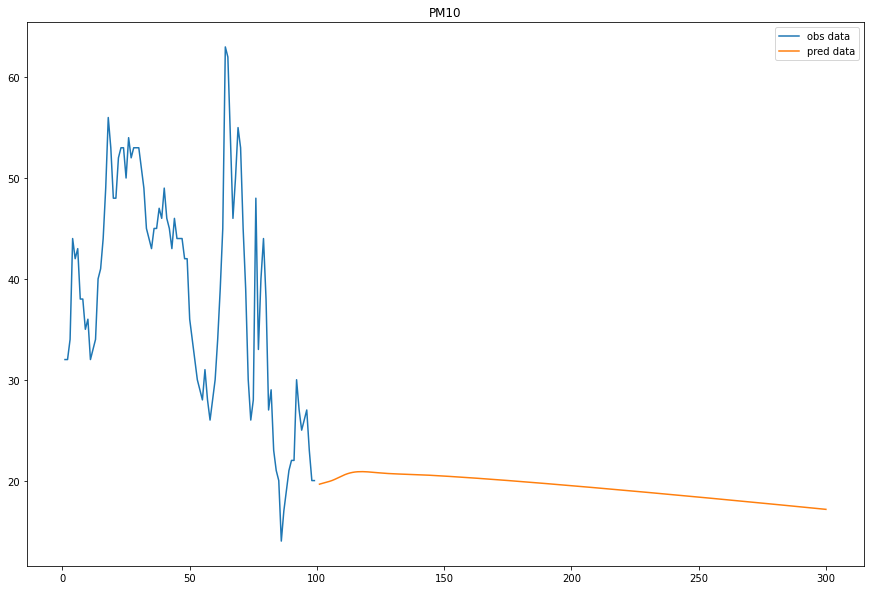

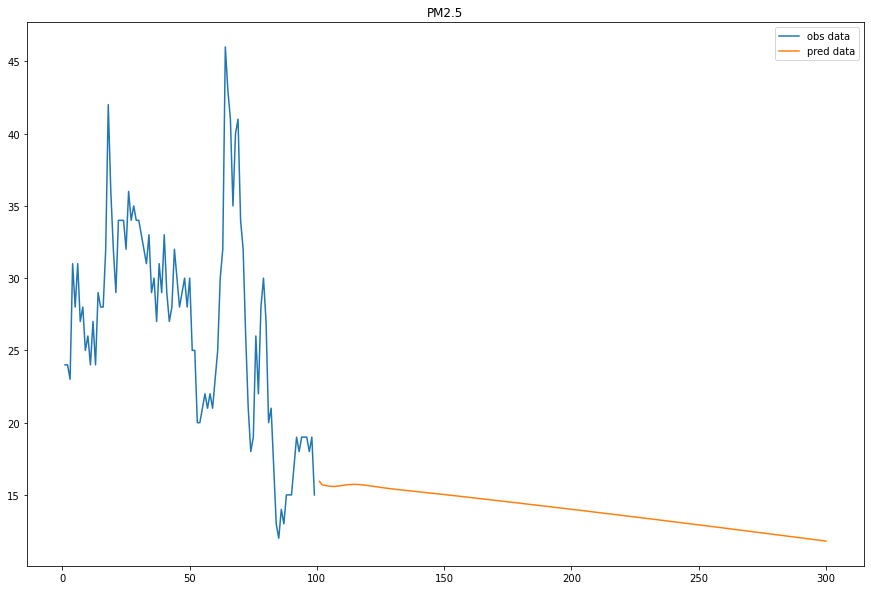

In [116]:
day_new=np.arange(1, 100)
day_pred=np.arange(101, 101 + time_predict)
print(f"Предикт для {time_predict} часов или {int(time_predict/24)} дней и {time_predict - 24*int(time_predict/24)} часов")
for indi, feature in enumerate(features):
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(10)
    plt.plot(day_new, scaler.inverse_transform(df1)[len(df1) - 99:,indi], label = 'obs data')
    plt.plot(day_pred, [i[indi] for i in scaler.inverse_transform(lst_output)], label = 'pred data')
    plt.title(feature)
    plt.legend()
    plt.show()